# Notebook Imports

In [1]:
!pip install prince

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.6/415.6 kB 7.7 MB/s eta 0:00:00


In [2]:
import os
import re
import pandas as pd
import numpy as np
from datetime import date
import seaborn as sns
from scipy import stats
from umap import UMAP
import re

import matplotlib.pyplot as plt
import warnings
from prince import MCA
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.manifold import TSNE

warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argume

# Constants

In [3]:
FILE = '/kaggle/input/data-science-for-good/Dept_11-00091/11-00091_Field-Interviews_2011-2015.csv'

# Step 1: Data Exploration and Preprocessing

### Load data

In [4]:
data = pd.read_csv(FILE)
df = pd.DataFrame(data)

df.drop([0], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,INCIDENT_UNIQUE_IDENTIFIER,INCIDENT_UNIQUE_IDENTIFIER.1,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,LOCATION_DISTRICT.1,INCIDENT_DATE,INCIDENT_TIME,SUBJECT_DETAILS,SUBJECT_RACE,...,VEHICLE_DETAILS.1,OFFICER_SUPERVISOR,OFFICER_ID,OFFICER_ASSIGNMENT,OFFICER_ASSIGNMENT.1,OFFICER_ETHNICITY,OFFICER_RACE,OFFICER_AGE,LOCATION_STREET_NUMBER,LOCATION_CITY
0,938283,621880,MALE,NORMANDY ST at SUPPLE RD,B2,3,12/10/13 0:00,12/10/13 0:00,YES,B(Black),...,MA,10132,98656,9999,OTHER,NaN,B(Black),59,3274,NO DATA ENTERED
1,881897,565177,MALE,75 BOYLSTON ST,A1,1,5/24/12 0:00,5/24/12 0:00,NO,W(White),...,NO DATA ENTERED,8949,9765,1,A1,NaN,W(White),26,543,OTHER
2,882060,565340,MALE,5 TOPLIFF ST,C11,5,6/4/12 0:00,6/4/12 0:00,YES,B(Black),...,NO DATA ENTERED,11312,83575,16,YVSF,NaN,B(Black),18,4493,NO DATA ENTERED
3,971623,653895,MALE,170 MORTON ST,B2,3,6/21/14 0:00,6/21/14 0:00,YES,B(Black),...,NO DATA ENTERED,9375,76146,25,BIKE,NaN,B(Black),24,3094,Dorchester
4,882761,566043,MALE,0 ST ALPHONSUS ST,B2,3,12/2/10 0:00,12/2/10 0:00,YES,B(Black),...,MA,NaN,107106,3,B2,NaN,B(Black),70,4241,Dorchester


In [5]:
print(f"\nThe shape of the data: {df.shape}\n")
print(f"The types of the data: \n{df.dtypes}\n")
print(f"The empty row in the data: \n{df.isnull().sum()}")


The shape of the data: (152230, 34)

The types of the data: 
INCIDENT_UNIQUE_IDENTIFIER                      object
INCIDENT_UNIQUE_IDENTIFIER.1                    object
SUBJECT_GENDER                                  object
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION    object
LOCATION_DISTRICT                               object
LOCATION_DISTRICT.1                             object
INCIDENT_DATE                                   object
INCIDENT_TIME                                   object
SUBJECT_DETAILS                                 object
SUBJECT_RACE                                    object
SUBJECT_DETAILS.1                               object
SUBJECT_DETAILS.2                               object
UNKNOWN_FIELD_TYPE                              object
UNKNOWN_FIELD_TYPE.1                            object
SEARCH_CONDUCTED                                object
SEARCH_REASON                                   object
INCIDENT_REASON                                 object
INC

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152230 entries, 0 to 152229
Data columns (total 34 columns):
 #   Column                                        Non-Null Count   Dtype 
---  ------                                        --------------   ----- 
 0   INCIDENT_UNIQUE_IDENTIFIER                    152230 non-null  object
 1   INCIDENT_UNIQUE_IDENTIFIER.1                  152230 non-null  object
 2   SUBJECT_GENDER                                152230 non-null  object
 3   LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION  152228 non-null  object
 4   LOCATION_DISTRICT                             152230 non-null  object
 5   LOCATION_DISTRICT.1                           152230 non-null  object
 6   INCIDENT_DATE                                 152230 non-null  object
 7   INCIDENT_TIME                                 152230 non-null  object
 8   SUBJECT_DETAILS                               131331 non-null  object
 9   SUBJECT_RACE                                  152230 non-nu

### Data Cleaning

In [7]:
# converting 'NO DATA ENTERED', 'UNKNOWN' values in columns to NaN values
for feature in df.columns:
    df[feature].replace(to_replace=["NO DATA ENTERED", 'UNKNOWN'], value=np.nan, inplace=True)

In [8]:
print(f"The empty row in the data: \n{df.isnull().sum()}")

The empty row in the data: 
INCIDENT_UNIQUE_IDENTIFIER                           0
INCIDENT_UNIQUE_IDENTIFIER.1                         0
SUBJECT_GENDER                                     237
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION         2
LOCATION_DISTRICT                                    0
LOCATION_DISTRICT.1                                  0
INCIDENT_DATE                                        0
INCIDENT_TIME                                        0
SUBJECT_DETAILS                                  22538
SUBJECT_RACE                                      6647
SUBJECT_DETAILS.1                                13621
SUBJECT_DETAILS.2                                22886
UNKNOWN_FIELD_TYPE                                   0
UNKNOWN_FIELD_TYPE.1                                 0
SEARCH_CONDUCTED                                131590
SEARCH_REASON                                   116686
INCIDENT_REASON                                  46908
INCIDENT_REASON.1                    

In [9]:
# dropping columns where the NaN values more then 30000
for feature in df.columns:
    if df[feature].isnull().sum() > 30000:
        df.drop([feature], axis=1, inplace=True)

In [10]:
df.shape

(152230, 24)

In [11]:
df.drop(['INCIDENT_UNIQUE_IDENTIFIER', 'INCIDENT_UNIQUE_IDENTIFIER.1', 'OFFICER_ID', 
         'INCIDENT_TIME', 'OFFICER_SUPERVISOR', 'OFFICER_ASSIGNMENT', 
         'LOCATION_STREET_NUMBER', 'SUBJECT_DETAILS.1', 'OFFICER_RACE'], axis=1, inplace=True)

In [12]:
df.shape

(152230, 15)

In [13]:
df.head()

,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,LOCATION_DISTRICT.1,INCIDENT_DATE,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,UNKNOWN_FIELD_TYPE,UNKNOWN_FIELD_TYPE.1,INCIDENT_REASON.1,DISPOSITION,VEHICLE_YEAR,OFFICER_ASSIGNMENT.1,OFFICER_AGE
0,MALE,NORMANDY ST at SUPPLE RD,B2,3,12/10/13 0:00,YES,B(Black),Med,IOFS,NO,"DRUGS, INVESTIGATION",SFO,2012,OTHER,59
1,MALE,75 BOYLSTON ST,A1,1,5/24/12 0:00,NO,W(White),Med,IO,NO,"DRUGS, POSSESSION",F,0,A1,26
2,MALE,5 TOPLIFF ST,C11,5,6/4/12 0:00,YES,B(Black),Dark,IOF,NO,"INVESTIGATE, PERSON",F,0,YVSF,18
3,MALE,170 MORTON ST,B2,3,6/21/14 0:00,YES,B(Black),Med,IOFS,NO,ABDW,S,0,BIKE,24
4,MALE,0 ST ALPHONSUS ST,B2,3,12/2/10 0:00,YES,B(Black),Light,IO,NO,VAL,F,2001,B2,70


In [14]:
print(f"The empty row in the data: \n{df.isnull().sum()}")

The empty row in the data: 
SUBJECT_GENDER                                    237
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION        2
LOCATION_DISTRICT                                   0
LOCATION_DISTRICT.1                                 0
INCIDENT_DATE                                       0
SUBJECT_DETAILS                                 22538
SUBJECT_RACE                                     6647
SUBJECT_DETAILS.2                               22886
UNKNOWN_FIELD_TYPE                                  0
UNKNOWN_FIELD_TYPE.1                                0
INCIDENT_REASON.1                                   0
DISPOSITION                                      8914
VEHICLE_YEAR                                      181
OFFICER_ASSIGNMENT.1                                0
OFFICER_AGE                                         0
dtype: int64


In [15]:
# Handling missing values
df['VEHICLE_YEAR'].replace([0, 0.0, '0'], value='UNKNOWN', inplace= True)
mode_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
mode_imputer.fit(df)
imputed_data = mode_imputer.transform(df)
df = pd.DataFrame(data=imputed_data, columns=df.columns)
df.isnull().sum()

SUBJECT_GENDER                                  0
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION    0
LOCATION_DISTRICT                               0
LOCATION_DISTRICT.1                             0
INCIDENT_DATE                                   0
SUBJECT_DETAILS                                 0
SUBJECT_RACE                                    0
SUBJECT_DETAILS.2                               0
UNKNOWN_FIELD_TYPE                              0
UNKNOWN_FIELD_TYPE.1                            0
INCIDENT_REASON.1                               0
DISPOSITION                                     0
VEHICLE_YEAR                                    0
OFFICER_ASSIGNMENT.1                            0
OFFICER_AGE                                     0
dtype: int64

### Data Preprocessing

In [16]:
# Extracting dates

df['INCIDENT_DATE'] = pd.to_datetime(df.INCIDENT_DATE, format="mixed")
df["INCIDENT_YEAR"] = df["INCIDENT_DATE"].dt.strftime('%Y')
df["INCIDENT_MONTH"] = df["INCIDENT_DATE"].dt.strftime('%m')
df["INCIDENT_WEEKDAY"] = df["INCIDENT_DATE"].dt.strftime('%w')
df['INCIDENT_DATE'] = df['INCIDENT_DATE'].dt.strftime('%d')

In [17]:
df.head()

,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,LOCATION_DISTRICT.1,INCIDENT_DATE,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,UNKNOWN_FIELD_TYPE,UNKNOWN_FIELD_TYPE.1,INCIDENT_REASON.1,DISPOSITION,VEHICLE_YEAR,OFFICER_ASSIGNMENT.1,OFFICER_AGE,INCIDENT_YEAR,INCIDENT_MONTH,INCIDENT_WEEKDAY
0,MALE,NORMANDY ST at SUPPLE RD,B2,3,10,YES,B(Black),Med,IOFS,NO,"DRUGS, INVESTIGATION",SFO,2012,OTHER,59,2013,12,2
1,MALE,75 BOYLSTON ST,A1,1,24,NO,W(White),Med,IO,NO,"DRUGS, POSSESSION",F,UNKNOWN,A1,26,2012,05,4
2,MALE,5 TOPLIFF ST,C11,5,04,YES,B(Black),Dark,IOF,NO,"INVESTIGATE, PERSON",F,UNKNOWN,YVSF,18,2012,06,1
3,MALE,170 MORTON ST,B2,3,21,YES,B(Black),Med,IOFS,NO,ABDW,S,UNKNOWN,BIKE,24,2014,06,6
4,MALE,0 ST ALPHONSUS ST,B2,3,02,YES,B(Black),Light,IO,NO,VAL,F,2001,B2,70,2010,12,4


In [18]:
# replace weird ages 
df['INCIDENT_YEAR'] = df['INCIDENT_YEAR'].astype(int)
replace = df[(df['INCIDENT_YEAR'] < 2011) | (df['INCIDENT_YEAR'] > 2015)]['INCIDENT_YEAR'].tolist()
value = round(df[(df['INCIDENT_YEAR'] >= 2011) | (df['INCIDENT_YEAR'] <= 2015)]['INCIDENT_YEAR'].mean())
df['INCIDENT_YEAR'].replace(to_replace=replace, value=value, inplace=True)

In [19]:
df['INCIDENT_YEAR'].value_counts()

INCIDENT_YEAR
2012    38703
2011    35227
2013    34825
2014    33981
2015     9494
Name: count, dtype: int64

In [20]:
def replace_values(feature, items, dict_, df=df):
    """
    This function used for replace the values in the dataframe.
    
    Parameters
    ----------
    
        feature: This parameter specifies the name of the column in the DataFrame (df) to modify.
    
        items: This parameter is a list of items to search for and replace in the specified DataFrame column.
    
        dict_: This parameter is a dictionary that maps replacement values. The keys in this dictionary represent the values 
               to be searched for in the items, and the corresponding values are the replacements.
           
        df: This parameter is an optional DataFrame parameter, with a default value set to ‘df’. 
            It represents the DataFrame in which the replacements should be made. 
    """
    for item in items:
        for key, values in dict_.items():            
            if any(value in item for value in values):
                df[feature].replace(item, value=key, inplace=True)                 
                break 

In [21]:
df['INCIDENT_REASON.1'].value_counts()

INCIDENT_REASON.1
INVESTIGATE, PERSON                     94365
VAL                                     21582
TRESPASSING                              4763
DRUGS, INVESTIGATION                     3603
INVESTIGATE, MV                          3544
                                        ...  
RECOVERED STOLEN PLATE                      1
FIREARM, SAWED OFF- POSSESSION              1
BREAKING GLASS, BLDG                        1
209A, MALICIOUS DESTRUCTION PROPERTY        1
CONCEALMENT OF RENTAL PROPERTY              1
Name: count, Length: 222, dtype: int64

In [22]:
list_ = df['INCIDENT_REASON.1'].unique().tolist()

dict_ = {
    'DRUGS': ['DRUGS', 'OVERDOSE'],
    '209A':  ['209A'],
    'ASSAULT': ['ASSAULT', 'A&B'],
    'PROSTITUTION': ['PROSTITUTION'],
    'ALCOHOL': ['PUBLIC DRINKING', 'ALCOHOL'],
    'ABDW': ['ABDW', 'A D/W'],
    'B&E': ['B&E'], 
    'MV': ['MV', 'M/V'], 
    'ROBBERY': ['ROBBERY', 'LARCENY', 'STOLEN'],
    'DISTURBING': ['DISTURBING', 'PEACE', 'LOUD PARTY', 'DISTURBANCE', 'NOISYHOUSE', 'NOISE'],
    'SEXUAL OFFENDER': ['SEXUAL OFFENDER', 'SEX-ASSAULT', 'RAPE', 'SEX', 'SEX-ASSAULT'], 
    'FIREARM': ['FIREARM', 'FIRE'], 
    'INVESTIGATE': ['INVESTIGATE', 'INVESTIGATION'],
    'HIT & RUN': ['HIT & RUN'],
    'SEARCH WARRANT': ['SEARCH WARRANT', 'WARRANTS'],
    'THREATS': ['THREATS', 'THREAT'],
    'CITY ORDINANCES': ['CITY ORDINANCES'],
    'MISSING PERSON': ['MISSING PERSON'],
    'PROPERTY DAMAGE': ['PROPERTY', 'DAMAGE'], 
    'HARASSMENT': ['HARASSMENT']
}

replace_values(feature='INCIDENT_REASON.1', items=list_, dict_=dict_, df=df)

In [23]:
len(df['INCIDENT_REASON.1'].value_counts())

88

In [24]:
# replace weird ages 
df['OFFICER_AGE'] = df['OFFICER_AGE'].astype(int)
replace = df[(df['OFFICER_AGE'] < 15) | (df['OFFICER_AGE'] > 75)]['OFFICER_AGE'].tolist()
value = round(df[(df['OFFICER_AGE'] >= 15) | (df['OFFICER_AGE'] <= 75)]['OFFICER_AGE'].mean())
df['OFFICER_AGE'].replace(to_replace=replace, value=value, inplace=True)

In [25]:
list_ = df['OFFICER_AGE'].value_counts().keys()

dict_ = {
    '10-20': [range(20)],
    '20-29': [range(20, 30)],
    '30-39': [range(30, 40)],
    '40-49': [range(40, 50)],
    '50-59': [range(50, 60)],
    '60-69': [range(60, 70)],
    '70+': [range(70, 80)],
}

for key, value_range in dict_.items():
    df['OFFICER_AGE'] = df['OFFICER_AGE'].replace({item: key for item in list_ if item in value_range})

In [26]:
df.head()

,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,LOCATION_DISTRICT.1,INCIDENT_DATE,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,UNKNOWN_FIELD_TYPE,UNKNOWN_FIELD_TYPE.1,INCIDENT_REASON.1,DISPOSITION,VEHICLE_YEAR,OFFICER_ASSIGNMENT.1,OFFICER_AGE,INCIDENT_YEAR,INCIDENT_MONTH,INCIDENT_WEEKDAY
0,MALE,NORMANDY ST at SUPPLE RD,B2,3,10,YES,B(Black),Med,IOFS,NO,DRUGS,SFO,2012,OTHER,59,2013,12,2
1,MALE,75 BOYLSTON ST,A1,1,24,NO,W(White),Med,IO,NO,DRUGS,F,UNKNOWN,A1,26,2012,05,4
2,MALE,5 TOPLIFF ST,C11,5,04,YES,B(Black),Dark,IOF,NO,INVESTIGATE,F,UNKNOWN,YVSF,18,2012,06,1
3,MALE,170 MORTON ST,B2,3,21,YES,B(Black),Med,IOFS,NO,ABDW,S,UNKNOWN,BIKE,24,2014,06,6
4,MALE,0 ST ALPHONSUS ST,B2,3,02,YES,B(Black),Light,IO,NO,VAL,F,2001,B2,70,2013,12,4


In [27]:
addresses = df['LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION'].unique().tolist()

# A pattern to match street names without numbers
patterns = [r'[^0-9]+ ST$', r'[^0-9]+$']  # This pattern matches words that end with ' ST' and have no numbers

# An empty dictionary to map old street names to new street names
street_name_mapping = {}

# Iterate through the addresses and extract street names
for address in addresses:
    parts = address.split(' at ', 1)  # Split at 'at'
    modified_address = parts[0].strip()
    for pattern in patterns:
        match = re.search(pattern, modified_address)
        if match:
            old_street_name = address
            new_street_name = match.group(0).strip()  # Remove leading/trailing spaces
            street_name_mapping[old_street_name] = new_street_name

# Use the .replace() method to replace old street names with new names
df['LOCATION_STREET_ADDRESS'] = df['LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION'].replace(street_name_mapping)

In [28]:
df.drop(['LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION'], axis=1, inplace=True)
df.head()

,SUBJECT_GENDER,LOCATION_DISTRICT,LOCATION_DISTRICT.1,INCIDENT_DATE,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,UNKNOWN_FIELD_TYPE,UNKNOWN_FIELD_TYPE.1,INCIDENT_REASON.1,DISPOSITION,VEHICLE_YEAR,OFFICER_ASSIGNMENT.1,OFFICER_AGE,INCIDENT_YEAR,INCIDENT_MONTH,INCIDENT_WEEKDAY,LOCATION_STREET_ADDRESS
0,MALE,B2,3,10,YES,B(Black),Med,IOFS,NO,DRUGS,SFO,2012,OTHER,59,2013,12,2,NORMANDY ST
1,MALE,A1,1,24,NO,W(White),Med,IO,NO,DRUGS,F,UNKNOWN,A1,26,2012,05,4,BOYLSTON ST
2,MALE,C11,5,04,YES,B(Black),Dark,IOF,NO,INVESTIGATE,F,UNKNOWN,YVSF,18,2012,06,1,TOPLIFF ST
3,MALE,B2,3,21,YES,B(Black),Med,IOFS,NO,ABDW,S,UNKNOWN,BIKE,24,2014,06,6,MORTON ST
4,MALE,B2,3,02,YES,B(Black),Light,IO,NO,VAL,F,2001,B2,70,2013,12,4,ST ALPHONSUS ST


### Data Encoding

In [29]:
df.dtypes

SUBJECT_GENDER             object
LOCATION_DISTRICT          object
LOCATION_DISTRICT.1        object
INCIDENT_DATE              object
SUBJECT_DETAILS            object
SUBJECT_RACE               object
SUBJECT_DETAILS.2          object
UNKNOWN_FIELD_TYPE         object
UNKNOWN_FIELD_TYPE.1       object
INCIDENT_REASON.1          object
DISPOSITION                object
VEHICLE_YEAR               object
OFFICER_ASSIGNMENT.1       object
OFFICER_AGE                 int64
INCIDENT_YEAR               int64
INCIDENT_MONTH             object
INCIDENT_WEEKDAY           object
LOCATION_STREET_ADDRESS    object
dtype: object

In [30]:
for feature in df.columns:
    df[feature] = df[feature].astype(str)

In [31]:
# Label encoding
label_df = df.copy()

le = LabelEncoder()
for col in label_df.columns:
    label_df[col] = le.fit_transform(df[col])
    
label_df.head()

,SUBJECT_GENDER,LOCATION_DISTRICT,LOCATION_DISTRICT.1,INCIDENT_DATE,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,UNKNOWN_FIELD_TYPE,UNKNOWN_FIELD_TYPE.1,INCIDENT_REASON.1,DISPOSITION,VEHICLE_YEAR,OFFICER_ASSIGNMENT.1,OFFICER_AGE,INCIDENT_YEAR,INCIDENT_MONTH,INCIDENT_WEEKDAY,LOCATION_STREET_ADDRESS
0,1,4,16,9,1,1,5,7,0,28,5,72,22,44,2,11,2,2359
1,1,0,0,23,0,5,5,5,0,28,0,83,0,11,1,4,4,482
2,1,8,18,3,1,1,2,6,0,49,0,83,25,3,1,5,1,3123
3,1,4,16,20,1,1,5,7,0,1,3,83,6,9,3,5,6,2142
4,1,4,16,1,1,1,4,5,0,80,0,50,4,55,2,11,4,2957


# Step 2: Data Visualization

### Gender and Race Distribution

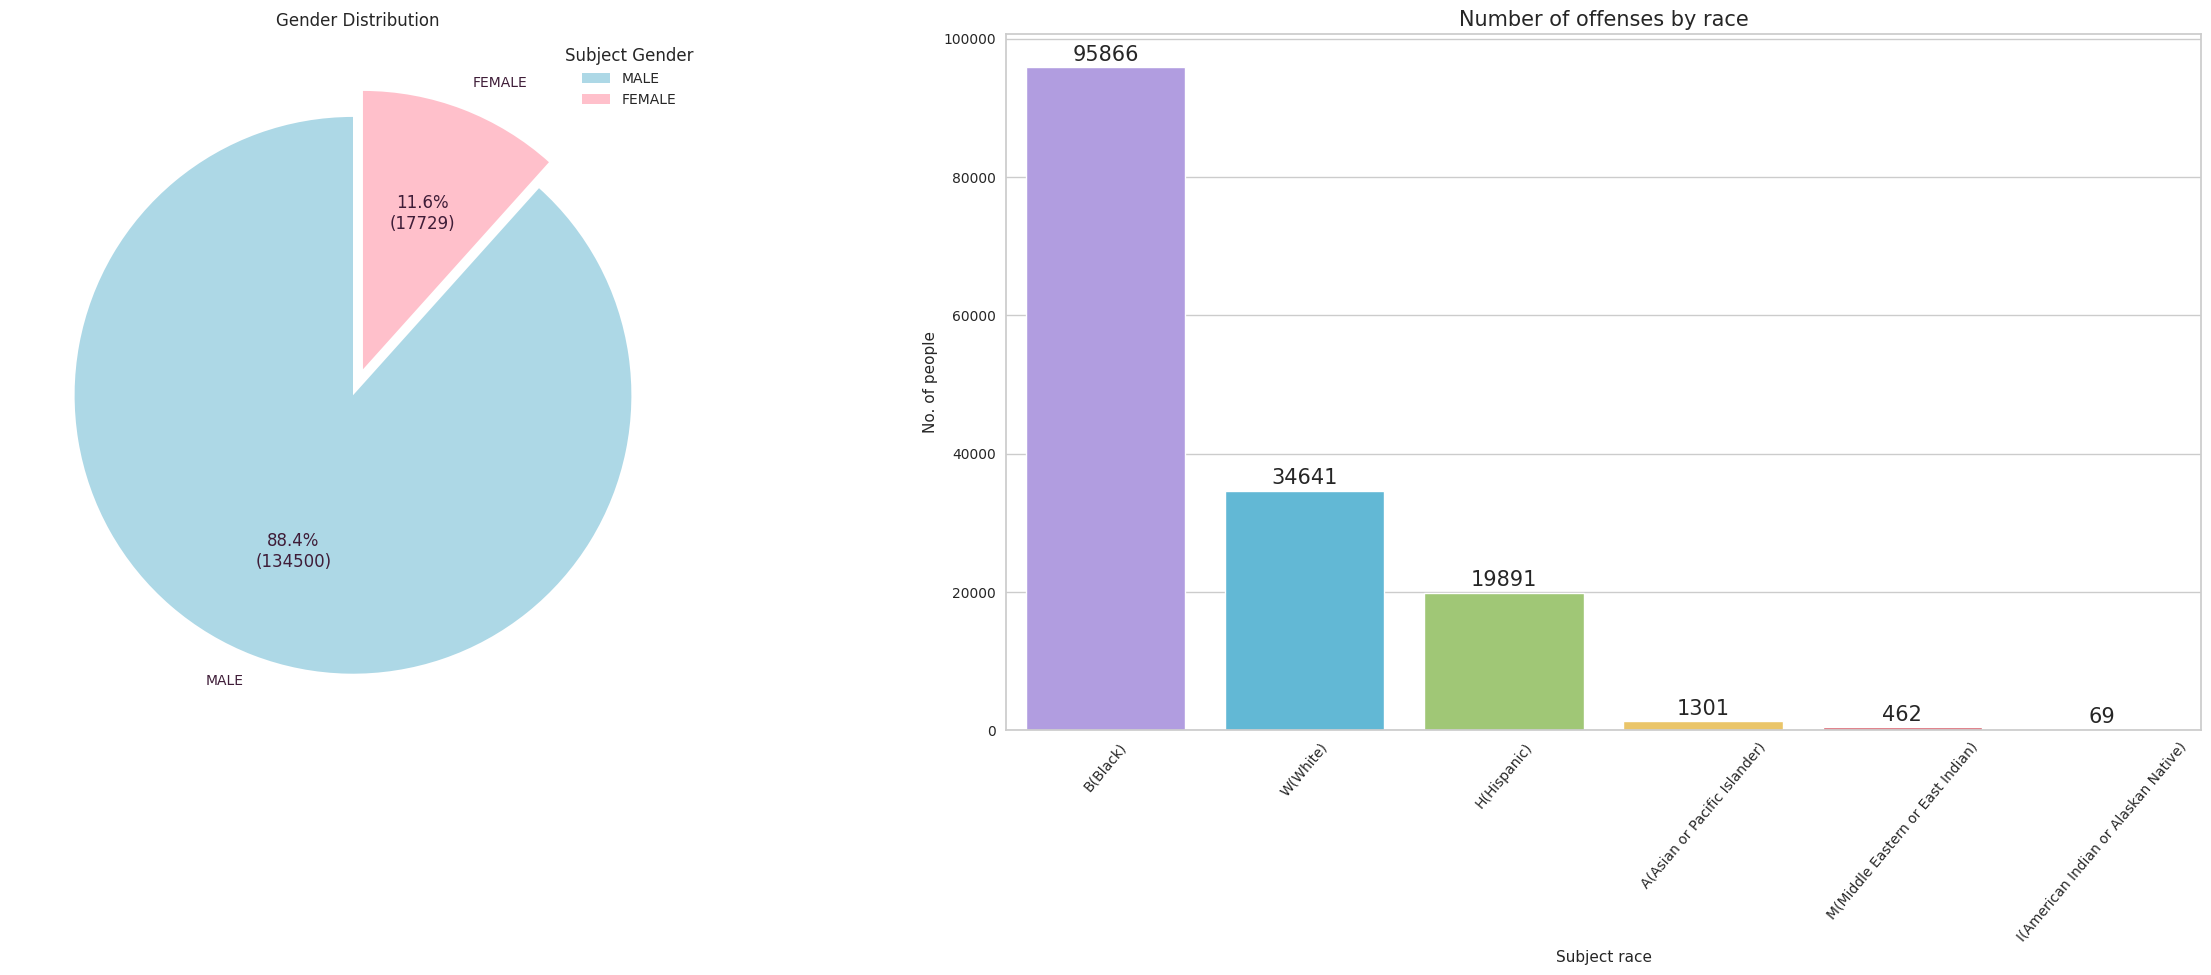

In [32]:
data = [len(df[df['SUBJECT_GENDER'] == feature]) for feature in df['SUBJECT_GENDER'].value_counts().index[0:2]]
labels = ['MALE', 'FEMALE']

colors = ['lightblue', 'pink']
explode = (0.05, 0.05)

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Creating the pie chart
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
plt.pie(data, labels=labels, explode=explode, colors=colors, 
        autopct=lambda pct: func(pct, data), startangle=90, textprops=dict(color="#3F1D38"))

plt.legend(labels, title="Subject Gender")
plt.title("Gender Distribution")

# Creating the bar chart
plt.subplot(1, 2, 2)
order = df['SUBJECT_RACE'].value_counts().index
colors = ['#AC92EB', '#4FC1E8', '#A0D568', '#FFCE54', '#ED5564', '#9E9FA5']

# Set the font size for titles
sns.set(font_scale=1.25)

ax = sns.countplot(data=df, x='SUBJECT_RACE', order=order, palette=colors) 

for label in ax.containers[0]:
    ax.annotate(format(int(label.get_height())), 
                (label.get_x() + label.get_width() / 2., label.get_height()), 
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')

plt.xticks(rotation=50)
plt.title('Number of offenses by race')
plt.xlabel('Subject race')
plt.ylabel('No. of people')

# Show plots
plt.tight_layout()
plt.show()

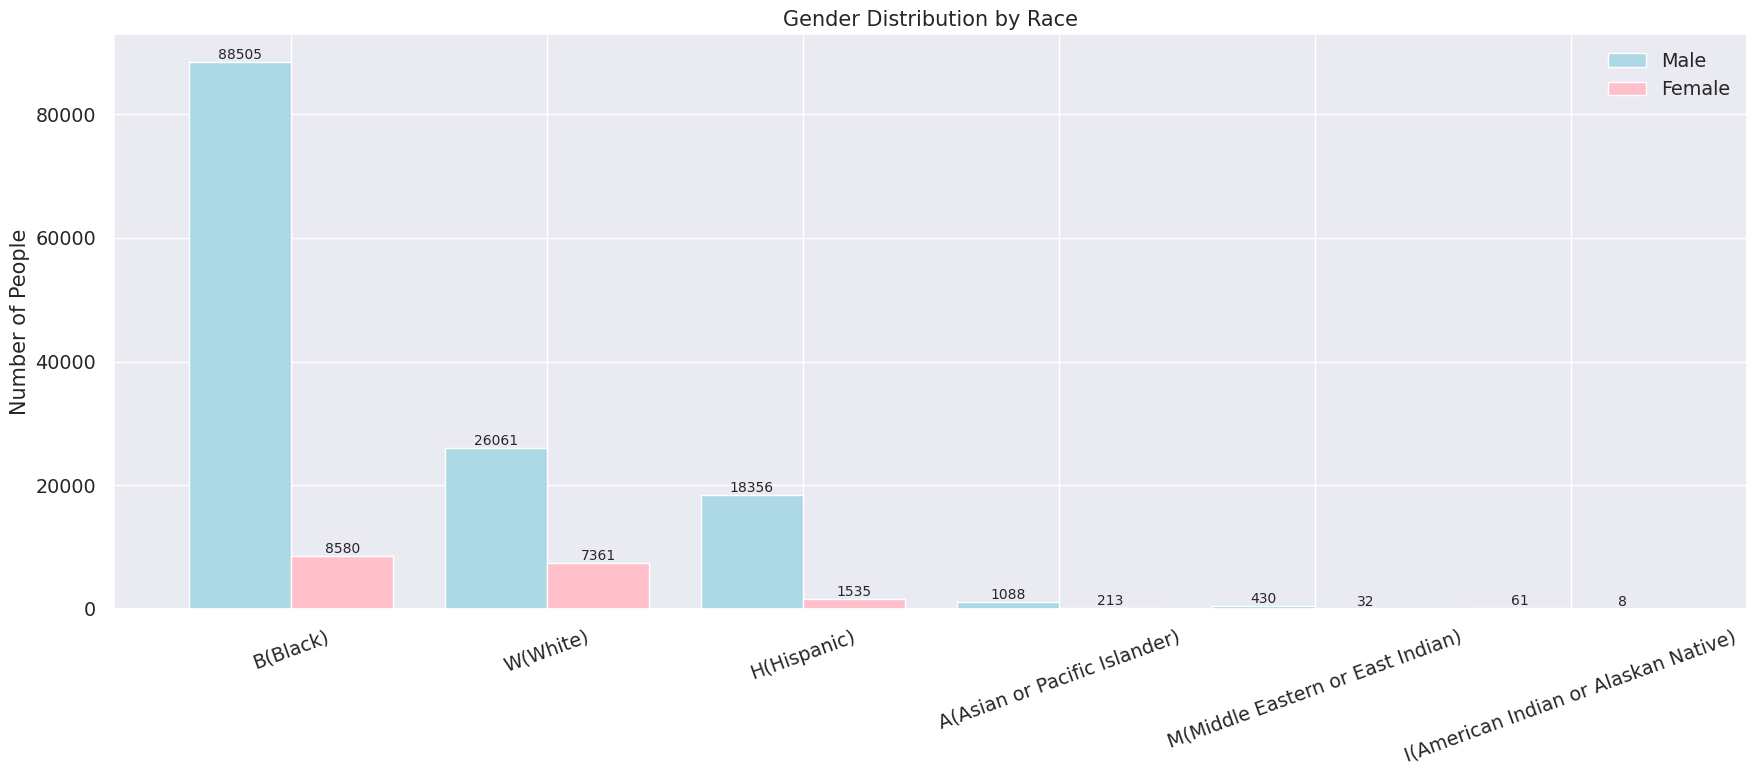

In [33]:
# Set the figure size
plt.figure(figsize=(18, 8))

# Extract the unique race categories to plot
race_to_plot = df['SUBJECT_RACE'].value_counts().keys()

# Filter data for male and female subjects
male = df[df['SUBJECT_GENDER'] == 'MALE']
female = df[df['SUBJECT_GENDER'] == 'FEMALE']

# Count the occurrences of gender and race combinations for male and female
values = [male['SUBJECT_RACE'].value_counts(), 
          female['SUBJECT_RACE'].value_counts()]

# Set up positions for the bars
x = np.arange(len(race_to_plot))
width = 0.4  # Width of the bars
colors = ['lightblue', 'pink']  # Colors for male and female bars

# Create the bar plots
plt.bar(x - width/2, values[0], width, color=colors[0], label='Male')
plt.bar(x + width/2, values[1], width, color=colors[1], label='Female')

# Annotate the bars with their values
for i in range(len(race_to_plot)):
    plt.text(x[i] - width/2, values[0][i], str(values[0][i]), ha='center', va='bottom', fontsize=10)
    plt.text(x[i] + width/2, values[1][i], str(values[1][i]), ha='center', va='bottom', fontsize=10)

# Set the x-axis labels and tick rotation
plt.xticks(x, race_to_plot, rotation=20)

# Set labels, legend, and title
plt.ylabel("Number of People")
plt.legend()
plt.title("Gender Distribution by Race")

# Display the plot
plt.tight_layout()
plt.show()

### Number of offences distrubuted by Years and Months

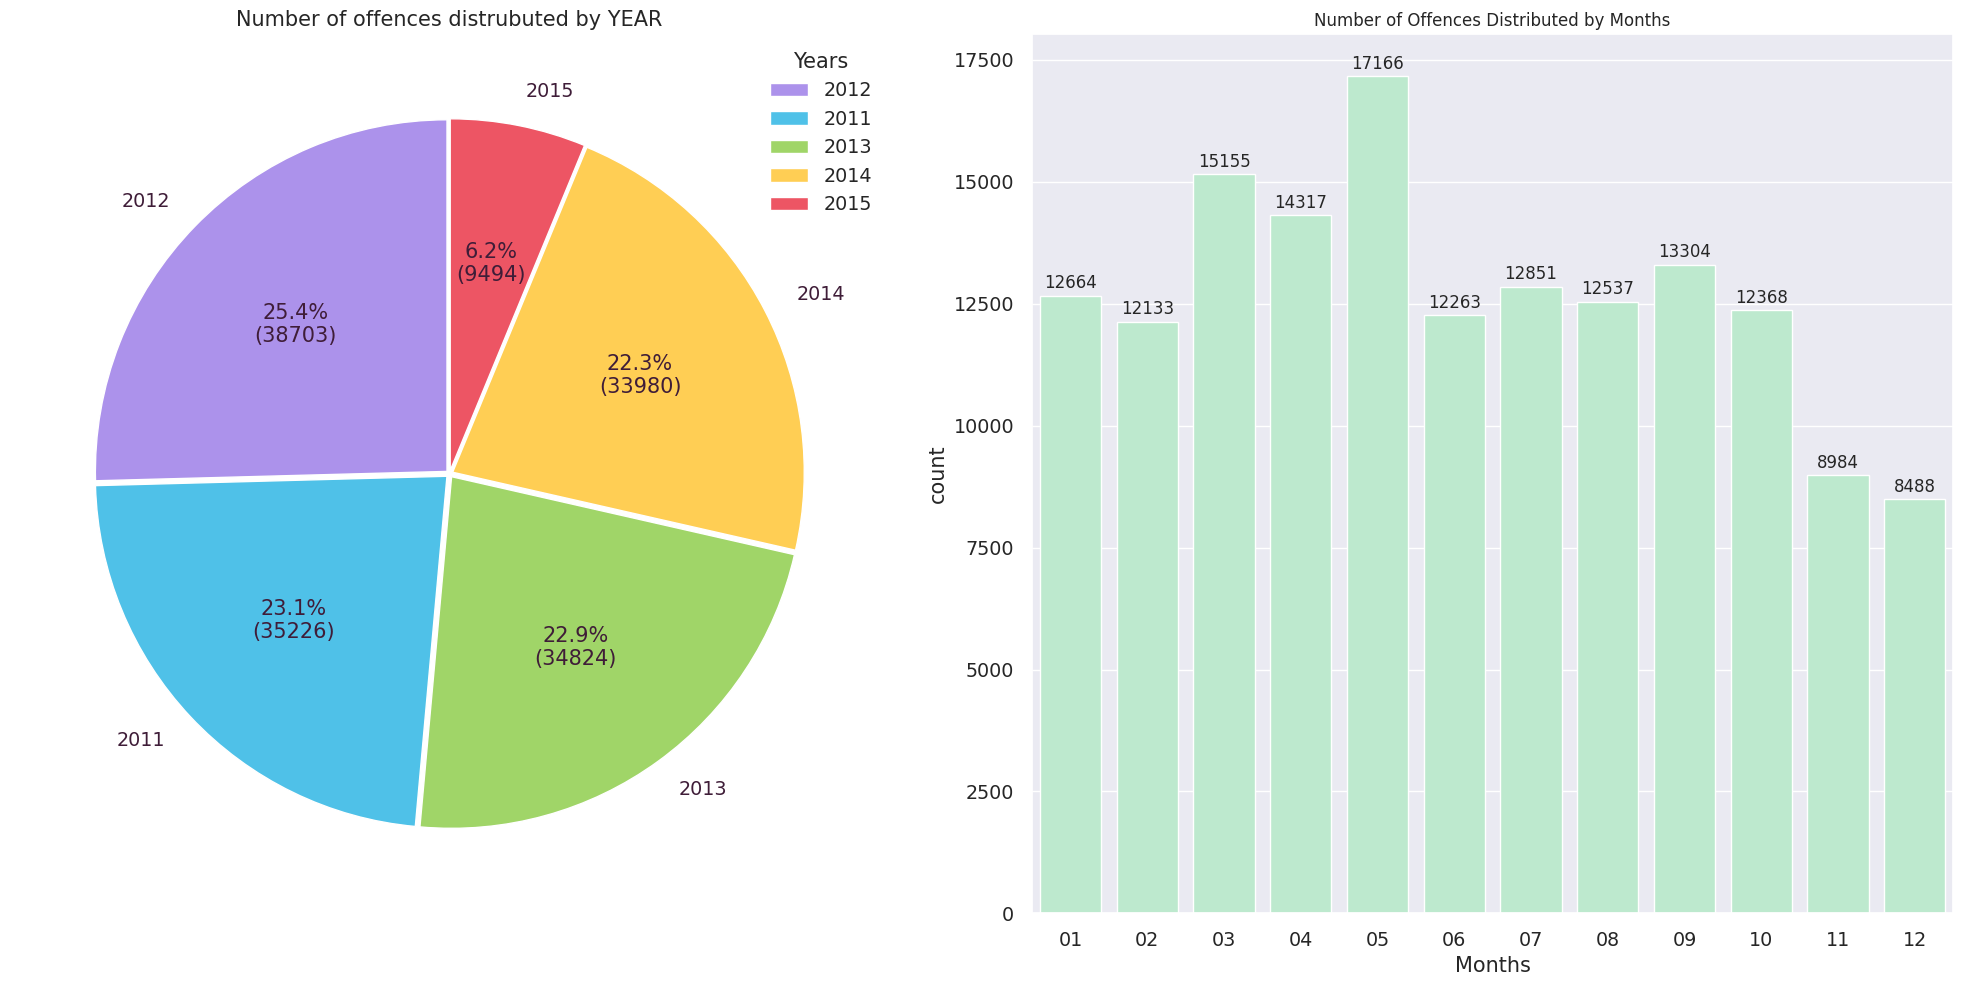

In [34]:
# Pie Chart

# Creating data
data = [len(df[df['INCIDENT_YEAR'] == feature]) for feature in df['INCIDENT_YEAR'].value_counts().index]
labels = df['INCIDENT_YEAR'].value_counts().index

colors = ['#AC92EB', '#4FC1E8', '#A0D568', '#FFCE54', '#ED5564'] # creating color parameters
explode = (0.01, 0.01, 0.01, 0.01, 0.01) # creating explode data

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Creating plot
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.pie(data, labels=labels, explode=explode, colors=colors, autopct=lambda pct: func(pct, data), 
        startangle=90, textprops=dict(color ="#3F1D38"))

# Adding legend
plt.legend(labels, title ="Years", loc ='best',)

plt.title("Number of offences distrubuted by YEAR")

# Bat chart
plt.subplot(1, 2, 2)
order = df['INCIDENT_MONTH'].value_counts().sort_index().index

# Set the font size for titles
sns.set(font_scale=1)

ax = sns.countplot(data=df, x='INCIDENT_MONTH', order=order, color='#B5F1CC') 

for label in ax.containers[0]:
    ax.annotate(format(int(label.get_height())), 
                (label.get_x() + label.get_width() / 2., label.get_height()), 
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')
    
plt.title('Number of Offences Distributed by Months')
plt.xlabel('Months')

plt.tight_layout() 
plt.show()

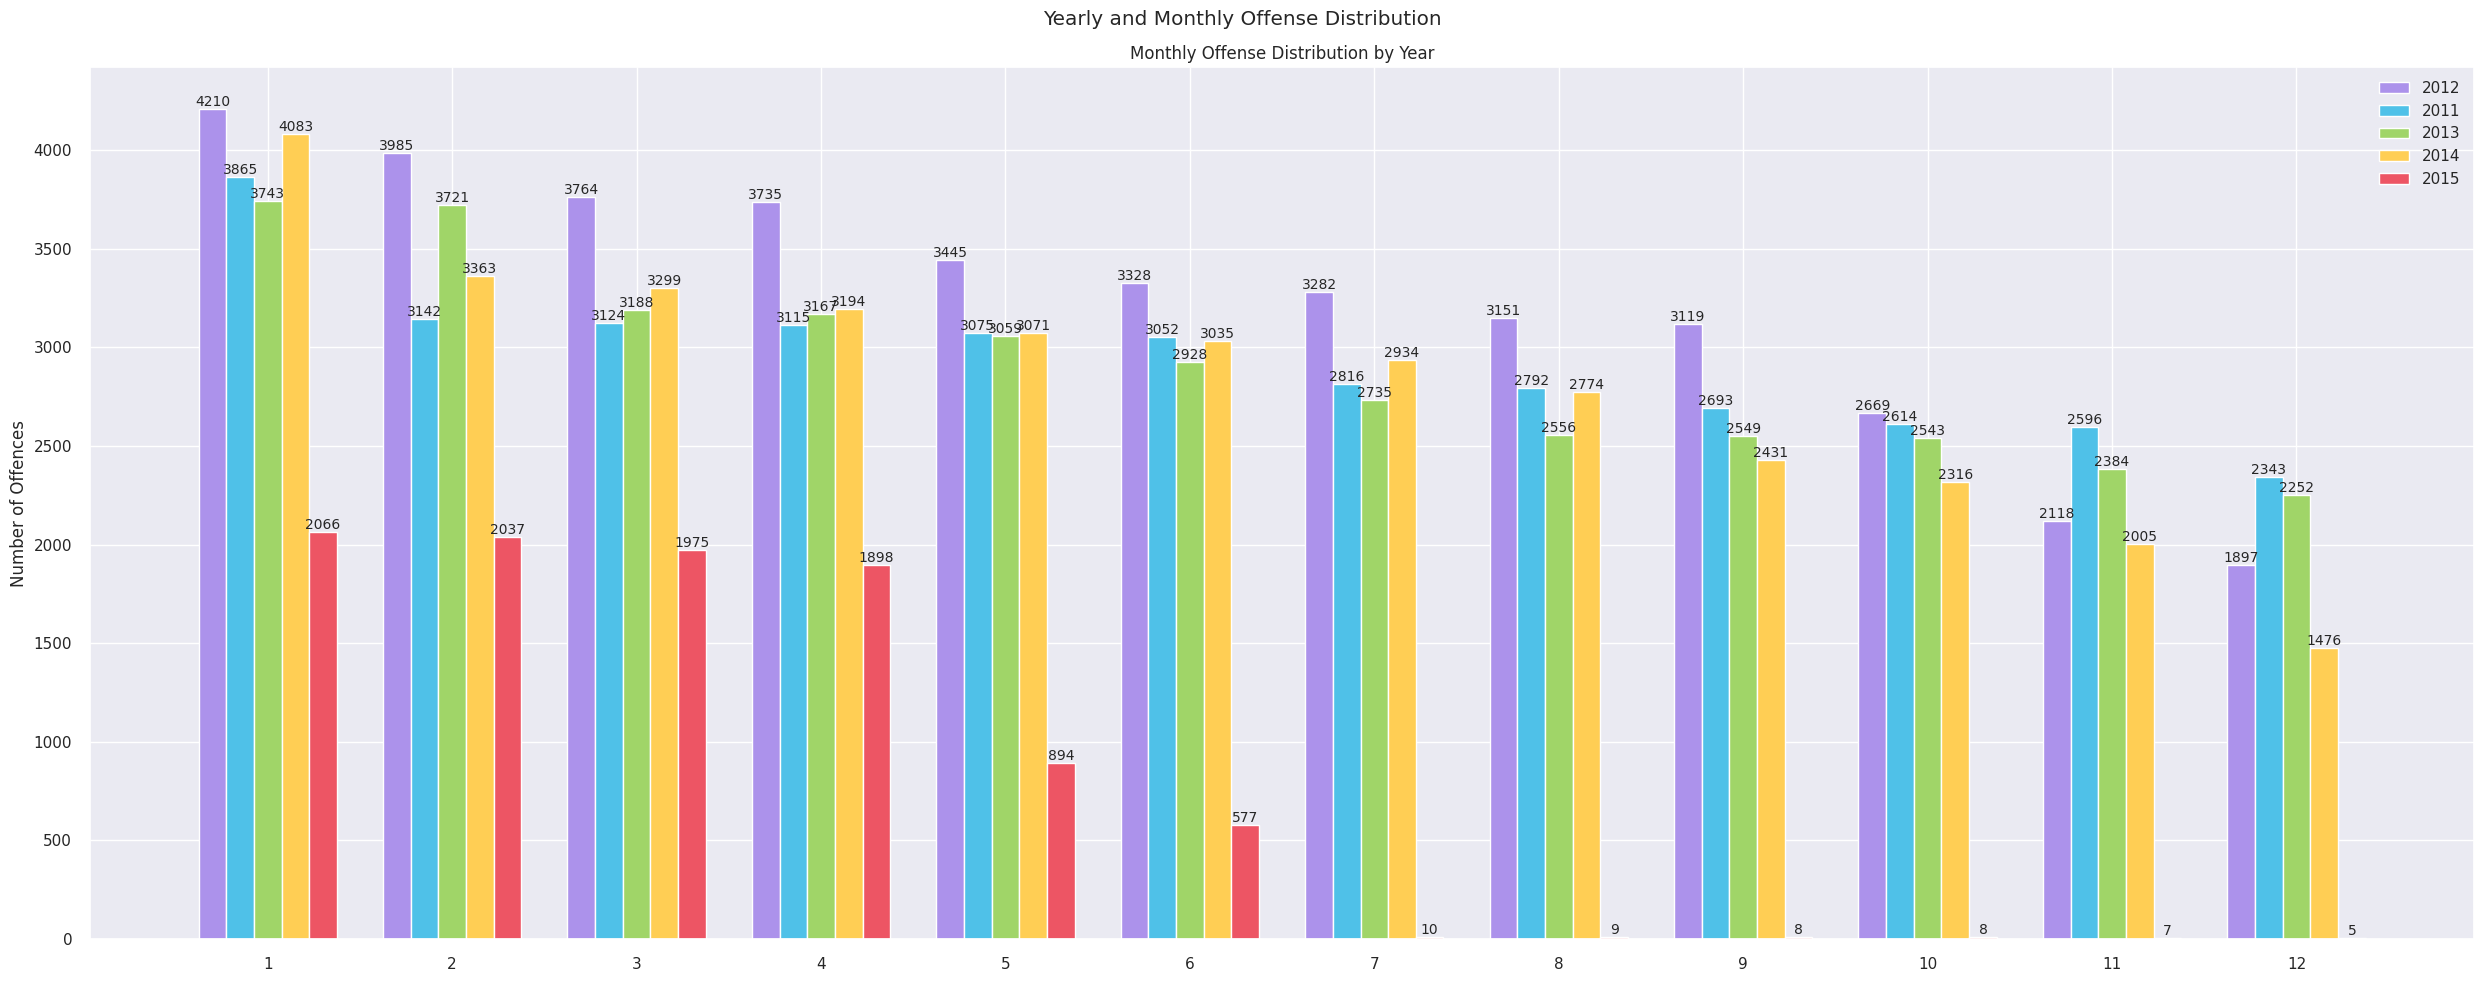

In [35]:
years_to_plot = df['INCIDENT_YEAR'].value_counts().keys()

# An empty list to store monthly counts for each year
values = []

for year in years_to_plot:
    c = df[df['INCIDENT_YEAR'] == year]
    value = c['INCIDENT_MONTH'].value_counts()
    values.append(value)

x = np.arange(1, 13)
width = 0.15
colors = ['#AC92EB', '#4FC1E8', '#A0D568', '#FFCE54', '#ED5564']

plt.figure(figsize=(25, 10))
for n in range(5):
    plt.bar(x + (n - 2) * width, values[n], width=width, color=colors[n])

# Annotate the bars with their values
for n in range(5):
    for i in range(12):
        plt.text(x[i] + (n - 2) * width, values[n][i], str(values[n][i]), ha='center', va='bottom', fontsize=10)

plt.xticks(x, [str(i) for i in range(1, 13)])
plt.ylabel("Number of Offences")
plt.legend(years_to_plot)  # Use the extracted unique years
plt.title("Monthly Offense Distribution by Year")

# Adding an overall title to the entire figure
plt.suptitle("Yearly and Monthly Offense Distribution")

# Show plots
plt.tight_layout()
plt.show()

### Number of offences distrubuted by Date and Weekdays

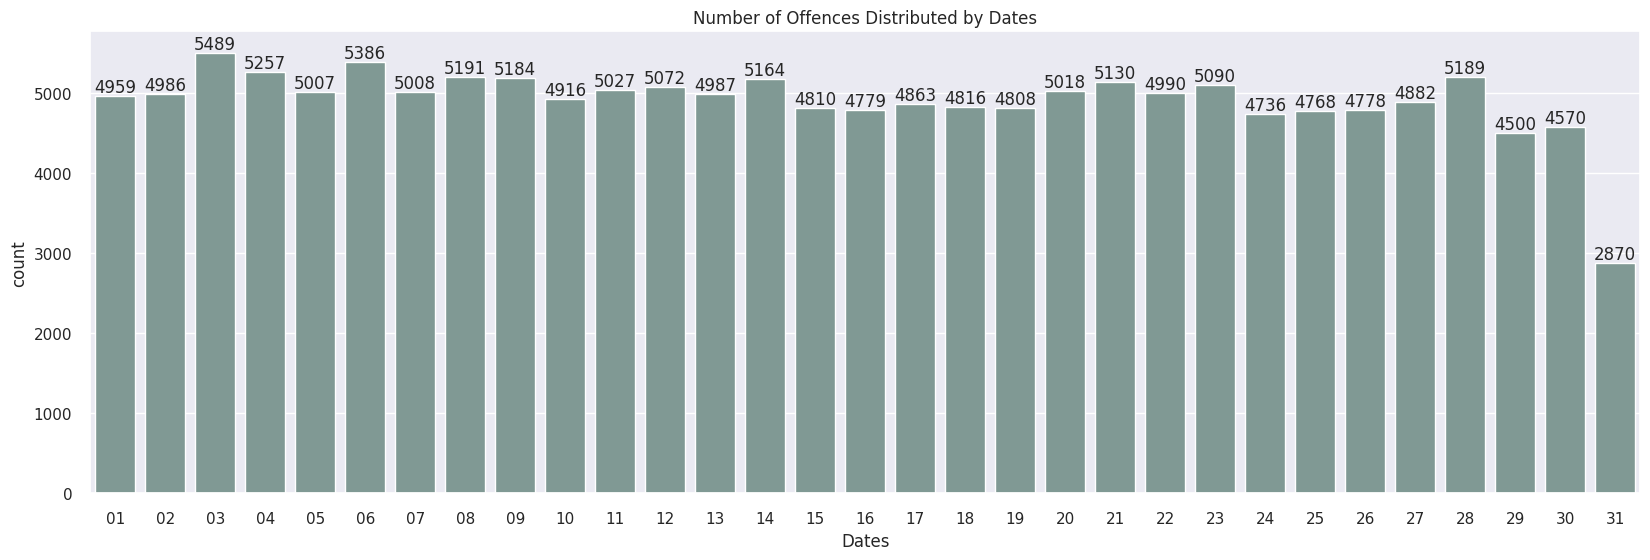

In [36]:
plt.figure(figsize=(20, 6))

# Set the font size for titles
sns.set(font_scale=1)

# Bar chart for dates
order = df['INCIDENT_DATE'].value_counts().sort_index().index
ax = sns.countplot(data=df, x='INCIDENT_DATE', order=order, color='#7C9D96')

for label in ax.containers:
    ax.bar_label(label)

plt.title('Number of Offences Distributed by Dates')
plt.xlabel('Dates')
sns.set(font_scale=1.25)

plt.show()

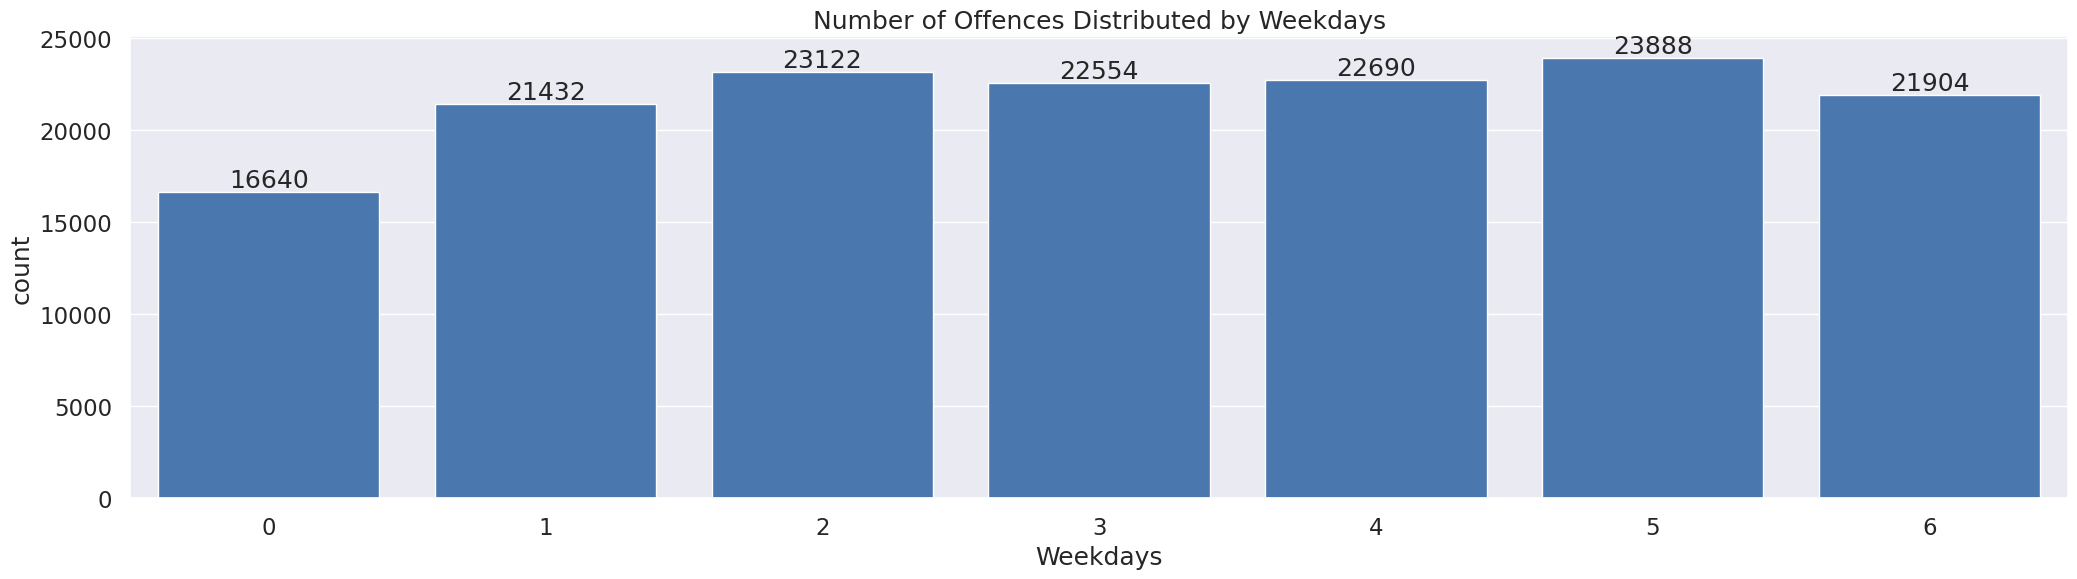

In [37]:
# Bar chart for weekdays
plt.figure(figsize=(25, 6))
order = df['INCIDENT_WEEKDAY'].value_counts().sort_index().index

# Set the font size for titles
sns.set(font_scale=1.5)

ax = sns.countplot(data=df, x='INCIDENT_WEEKDAY', order=order, color='#3876BF')

for label in ax.containers:
    ax.bar_label(label)
    
plt.title('Number of Offences Distributed by Weekdays')
plt.xlabel('Weekdays')

plt.show()

### Number of Offences Distributed by Location

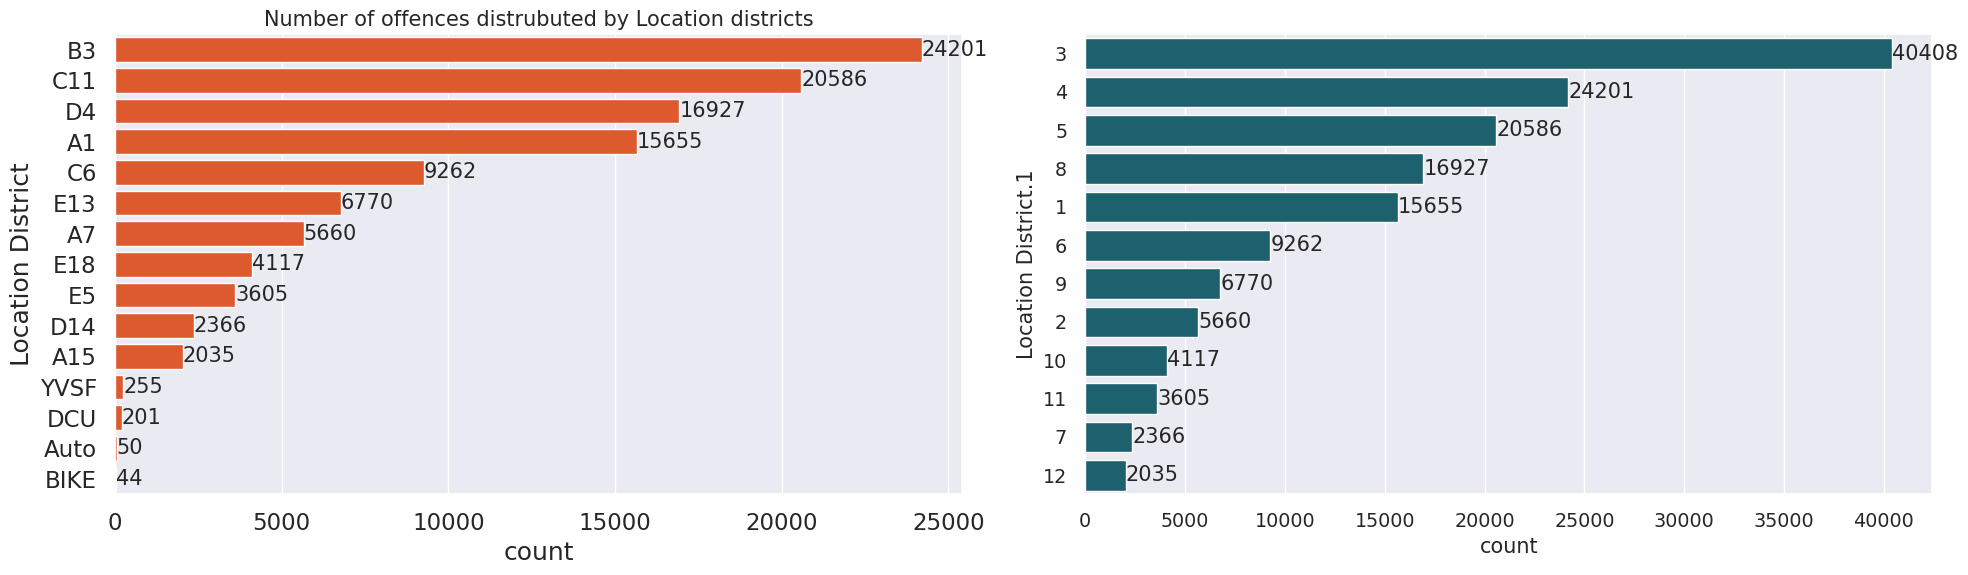

In [38]:
# Bar chart 1: Location district
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
order = df['LOCATION_DISTRICT'].value_counts().index[1:16]

# Set the font size for titles
sns.set(font_scale=1.25)

ax = sns.countplot(y=df['LOCATION_DISTRICT'], order=order, color='#F94C10')

for label in ax.containers:
    ax.bar_label(label)

plt.title('Number of offences distrubuted by Location districts')
plt.ylabel('Location District')

# Bar chart 2: Location district.1
plt.subplot(1, 2, 2)
order = df['LOCATION_DISTRICT.1'].value_counts().index[:12]
ax = sns.countplot(y=df['LOCATION_DISTRICT.1'], order=order, color='#116A7B')

for label in ax.containers:
    ax.bar_label(label)

plt.ylabel('Location District.1')

plt.tight_layout() 
plt.show()

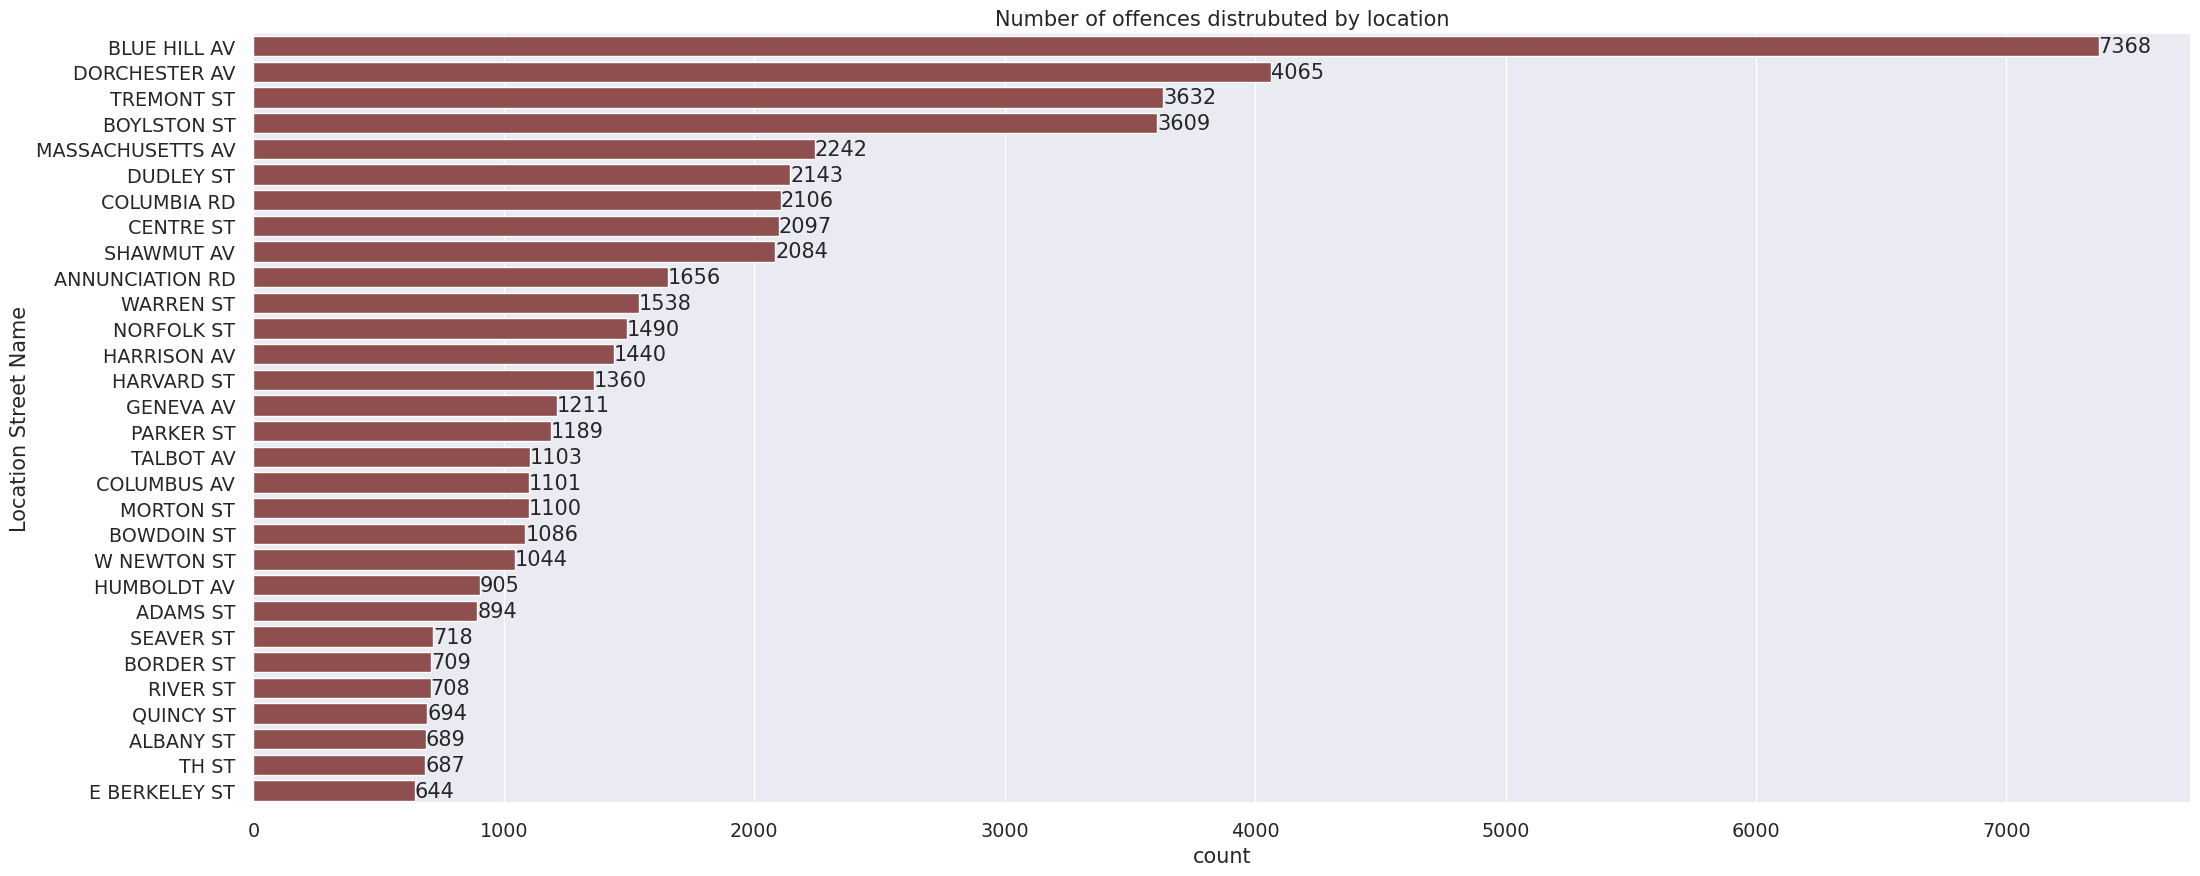

In [39]:
# Bar chart 1: Location
plt.figure(figsize=(25, 10))
order = df['LOCATION_STREET_ADDRESS'].value_counts().index[1:31]

# Set the font size for titles
sns.set(font_scale=1.25)

ax = sns.countplot(y=df['LOCATION_STREET_ADDRESS'], order=order, color='#9A4444')

for label in ax.containers:
    ax.bar_label(label)

plt.title('Number of offences distrubuted by location')
plt.ylabel('Location Street Name')

plt.show()

# Step 3: Dimensionality Reduction